<a href="https://colab.research.google.com/github/SorenPrado/ibmec-soren/blob/main/Trabalho_final_IBMEC_Inteligencia_de_Investimento_Ativada_por_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Inteligência de Investimento Ativada por IA**

**aluno: Sóren Prado, MBA Data Science & BI**

*IBMEC*

Matricula: 202208892426

Linkedin: http://www.linkedin.com/in/soren-prado


# **"Inteligência de Investimento Ativada por IA"**

#### O Problema:
No mundo volátil dos mercados financeiros, os investidores estão sempre em busca de estratégias mais robustas e informadas. A gestão eficaz de portfólio e a minimização de riscos são críticas, mas frequentemente desafiadoras.

#### A Solução:
Apresentamos uma plataforma baseada em Spark que utiliza aprendizado de máquina para aprimorar as estratégias de investimento. Com a ajuda da biblioteca MLlib e da API PySpark, nossa solução oferece:

1. **Previsão de Movimento de Preços**: Utilizando árvores de decisão e florestas aleatórias, nosso modelo pode classificar a tendência futura dos preços de ativos com uma precisão significativa.

2. **Clusterização de Volatilidade**: Usando o algoritmo K-Means, identificamos clusters de ativos com padrões de volatilidade semelhantes, proporcionando uma nova dimensão para estratégias de diversificação de portfólio.

#### Benefícios:

- **Informações Acionáveis**: Fornecemos insights que podem ser imediatamente aplicados em estratégias de hedging, alocação de ativos e identificação de oportunidades de investimento.
  
- **Adaptável e Escalável**: A solução pode ser adaptada para diferentes classes de ativos e é escalável para conjuntos de dados maiores, graças ao poder do Spark.

- **Minimização de Risco**: Ao entender melhor as categorias de volatilidade e as tendências de preço, os investidores podem tomar decisões mais informadas, minimizando riscos.

#### Conclusão:
Nossa solução oferece uma abordagem data-driven para o mundo dos investimentos, tornando as estratégias mais robustas e informadas. Com nossa plataforma, você está não apenas investindo em ativos, mas também investindo em inteligência.

# **1. Definição do Escopo**
Fontes de Dados: Usar a biblioteca yfinance para obter dados históricos de ativos financeiros.
Objetivos:
Utilizar uma árvore de classificação para prever se a volatilidade de um ativo será alta ou baixa em um determinado período.
Utilizar métodos de clusterização para segmentar ativos com base em padrões de volatilidade.


**Pre-Requisitos**

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

**Configuracao das Variaveis de Ambiente**

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

**Iniciar Spark**

In [4]:
import findspark
findspark.init()


**Importar os pacotes**

In [5]:
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# **2. Preparação de Dados**
Importação de bibliotecas e obtenção de dados históricos.
*Utilizamos dados históricos da ação da Apple (AAPL) para o ano de 2022 até hoje. Os dados incluem o preço de abertura, o preço mais alto, o preço mais baixo, o preço de fechamento e o volume de negociações para cada dia de negociação.

Cálculo de métricas de volatilidade e outras características relevantes.
*Calculamos o retorno diário e a volatilidade dos últimos 21 dias para cada dia de negociação.

Remoção das linhas com valores null nas colunas 'Daily_Return' e 'Volatility' para um conjunto de dados limpo e pronto para a próxima fase de análise.
*Limpeza de Dados: Removemos as linhas com valores null nas colunas de retorno diário e volatilidade. Isso é importante para assegurar que o modelo de aprendizado de máquina não seja treinado ou testado com dados incompletos ou enganosos.

In [6]:
import yfinance as yf

# Uma sessão do Spark foi iniciada para manipular dados distribuídos e realizar cálculos em paralelo.
spark = SparkSession.builder.appName("VolatilityPrediction").getOrCreate()

# Download historical data using yfinance
data = yf.download('AAPL', start='2022-01-01', end='2023-09-21')

# Convert the data to a Spark DataFrame
sdf = spark.createDataFrame(data.reset_index())

# Calculate daily returns and volatility
sdf = sdf.withColumn('Daily_Return', (F.col('Close') / F.lag('Close').over(Window.orderBy('Date'))) - 1)
sdf = sdf.withColumn('Volatility', F.stddev('Daily_Return').over(Window.orderBy('Date').rowsBetween(-20, 0)))

# Remove rows with NULL values in 'Daily_Return' and 'Volatility'
sdf = sdf.filter((F.col('Daily_Return').isNotNull()) & (F.col('Volatility').isNotNull()))

[*********************100%%**********************]  1 of 1 completed


/content/spark-3.1.1-bin-hadoop3.2/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


##2.1 CONTEXTO - CONJUNTO DE DADOS

Após a importação desses dados, realizei duas transformações principais:

**Retorno Diário (Daily_Return)**:
coluna calculada tomando o preço de fechamento de um dia e dividindo pelo preço de fechamento do dia anterior, subtraindo 1 do resultado.
Um indicador comumente usado para entender como o preço de um ativo está mudando em uma base diária.
**Exemplo**: No dia 6 de janeiro de 2022, o retorno diário foi de aproximadamente -0.0167, indicando uma queda no preço do ativo em relação ao dia anterior.

**Volatilidade (Volatility)**: Esta coluna foi calculada usando o desvio padrão dos retornos diários ao longo de uma janela de 21 dias (20 dias anteriores mais o dia atual). A volatilidade é uma medida de quão errático é um ativo, e é frequentemente usado em estratégias de gerenciamento de risco.
**Exemplo**: No dia 7 de janeiro de 2022, a volatilidade foi de aproximadamente 0.0114, o que sugere que o preço da ação teve um certo nível de flutuação.


In [7]:
sdf.show()

+-------------------+------------------+------------------+------------------+------------------+------------------+---------+--------------------+--------------------+
|               Date|              Open|              High|               Low|             Close|         Adj Close|   Volume|        Daily_Return|          Volatility|
+-------------------+------------------+------------------+------------------+------------------+------------------+---------+--------------------+--------------------+
|2022-01-05 00:00:00|179.61000061035156| 180.1699981689453|174.63999938964844| 174.9199981689453|173.17181396484375| 94537600|-0.02659988236212174|0.009834642667580593|
|2022-01-06 00:00:00| 172.6999969482422| 175.3000030517578|171.63999938964844|             172.0|  170.281005859375| 96904000|  -0.016693335236175|0.007160004365711642|
|2022-01-07 00:00:00|172.88999938964844|174.13999938964844|171.02999877929688| 172.1699981689453|170.44931030273438| 86709100|9.883614473564784E-4|0.011432

# ** 2.2 Abaixo, uma visualização simplificada do conjunto de dados, focando nas colunas mais relevantes para a nossa análise: `Date`, `Close`, `Daily_Return` e `Volatility`**
Abaixo uma visualização simplificada do conjunto de dados, focando nas colunas mais relevantes para a nossa análise: `Date`, `Close`, `Daily_Return` e `Volatility`.
- **Date**: Esta é a data do dia de negociação.
- **Close**: Este é o preço de fechamento da ação da Apple Inc. (AAPL) para cada dia. Por exemplo, no dia 5 de janeiro de 2022, o preço de fechamento foi de aproximadamente 174.92 USD.

- **Daily_Return**: Este é o retorno diário, que indica a variação percentual do preço de fechamento em relação ao dia anterior. Valores negativos, como o -0.0266 em 5 de janeiro de 2022, indicam uma queda no preço, enquanto valores positivos indicam um aumento.

- **Volatility**: Esta é a volatilidade calculada com base no desvio padrão dos últimos 21 dias de retorno diário. Valores mais altos, como o 0.0213 em 28 de janeiro de 2022, sugerem maior incerteza ou risco associado ao ativo.

### Observações:

1. **Alta Volatilidade**: Em 28 de janeiro de 2022, observamos uma alta volatilidade de 0.0213, juntamente com um aumento significativo no retorno diário de 0.0698. Isso poderia ser um indicativo de um evento de mercado ou uma mudança significativa na percepção dos investidores sobre o ativo.

2. **Retornos Negativos**: Dias como 19 de janeiro de 2022, que teve um retorno diário de -0.0210 e uma volatilidade de 0.0138, poderiam ser de interesse para estratégias de hedging ou de venda a descoberto.

3. **Dias Calmos**: Alguns dias, como 7 de janeiro de 2022, apresentam uma volatilidade relativamente baixa de 0.0114 e um retorno diário próximo de zero (0.000988). Estes poderiam ser considerados dias "calmos" para o ativo.


In [8]:
sdf.select('Date', 'Close', 'Daily_Return', 'Volatility').show()

+-------------------+------------------+--------------------+--------------------+
|               Date|             Close|        Daily_Return|          Volatility|
+-------------------+------------------+--------------------+--------------------+
|2022-01-05 00:00:00| 174.9199981689453|-0.02659988236212174|0.009834642667580593|
|2022-01-06 00:00:00|             172.0|  -0.016693335236175|0.007160004365711642|
|2022-01-07 00:00:00| 172.1699981689453|9.883614473564784E-4|0.011432733856099782|
|2022-01-10 00:00:00|172.19000244140625|1.161890728564873...|0.011682460140007577|
|2022-01-11 00:00:00| 175.0800018310547|0.016783781570778755|0.015414883545614148|
|2022-01-12 00:00:00|175.52999877929688|0.002570236140826...|0.014470012625679488|
|2022-01-13 00:00:00|172.19000244140625|-0.01902806563617...|0.014276030256251236|
|2022-01-14 00:00:00|173.07000732421875|0.005110661887074208|0.013933526386886056|
|2022-01-18 00:00:00| 169.8000030517578|-0.01889411298362...|0.013803213324418365|
|202

# **Logo abaixo, o método `describe` exibe estatísticas descritivas para as colunas `Daily_Return` e `Volatility`. Isso nos dá um resumo quantitativo que pode ser muito útil para entender a distribuição e a variação dessas métricas.**

### Daily_Return
- **Count**: 429 dias de negociação têm dados de retorno diário disponíveis.
- **Mean**: O retorno diário médio é aproximadamente  $1.31 \times 10^{-4}$ ou 0.0131%, o que é muito próximo de zero. Isso sugere que, em média, não houve um ganho ou perda significativa.
- **Stddev**: O desvio padrão é aproximadamente 0.0194, indicando a quantidade de variação ou dispersão do conjunto de retornos.
- **Min**: O menor retorno diário foi cerca de -5.87%, representando uma queda significativa no preço.
- **Max**: O maior retorno diário foi cerca de 8.90%, representando um aumento significativo no preço.

### Volatility

- **Count**: Também temos 429 observações para a volatilidade.
- **Mean**: A volatilidade média é aproximadamente 0.0183 ou 1.83%. Isso nos dá uma ideia da flutuação média dos retornos diários durante o período.
- **Stddev**: O desvio padrão da volatilidade é aproximadamente 0.0062, indicando a variação na volatilidade ao longo do tempo.
- **Min**: A menor volatilidade observada foi de cerca de 0.0072 ou 0.72%.
- **Max**: A maior volatilidade observada foi de cerca de 0.0347 ou 3.47%.

### Insights

1. **Variabilidade nos Retornos**: O alto desvio padrão nos retornos diários sugere que o ativo é bastante volátil, o que pode ser arriscado ou vantajoso, dependendo da sua estratégia de negociação.

2. **Flutuação da Volatilidade**: O desvio padrão da volatilidade também é notável, indicando que a volatilidade do ativo não é constante e varia significativamente.

3. **Extremos**: Os valores mínimos e máximos tanto para o retorno diário quanto para a volatilidade indicam dias de atividade excepcionalmente alta ou baixa, que podem ser de interesse para estratégias de negociação específicas.


In [9]:
sdf.describe('Daily_Return', 'Volatility').show()


+-------+--------------------+--------------------+
|summary|        Daily_Return|          Volatility|
+-------+--------------------+--------------------+
|  count|                 429|                 429|
|   mean| 1.31207224904716E-4|0.018322704507489306|
| stddev| 0.01935184805182522|0.006205443507003114|
|    min|-0.05867953721882391|0.007160004365711642|
|    max| 0.08897457132383879| 0.03465412975429641|
+-------+--------------------+--------------------+



# **Justificativa**
##A estratégia de calcular métricas como o retorno diário e a volatilidade para um período de 21 dias tem implicações significativas tanto para a análise de dados como para a modelagem preditiva. ##


### Retorno Diário
O **retorno diário** é uma medida de quanto o preço de um ativo variou de um dia para o outro. É calculado como:

$$
\text{Retorno Diário} = \frac{\text{Preço de Fechamento hoje}}{\text{Preço de Fechamento ontem}} - 1
$$

Esta métrica é fundamental para entender os movimentos de preço diários e pode ser um indicador de várias coisas, incluindo a saúde geral do mercado ou de um ativo específico. O retorno diário é uma métrica de "momento" que pode ser usada para entender a direção geral em que um ativo está se movendo.

### Volatilidade de 21 Dias
A **volatilidade** é uma medida estatística da dispersão de retornos para um dado ativo ou índice de mercado. Neste caso, estamos usando o desvio padrão dos últimos 21 dias dos retornos diários para calcular a volatilidade. A escolha de 21 dias é bastante comum e tem a ver com o número médio de dias de negociação em um mês no mercado de ações dos EUA.

$$
\text{Volatilidade} = \text{Desvio Padrão dos últimos 21 dias de Retorno Diário}
$$

### Por que essas métricas são importantes?

1. **Contexto Temporal**: A volatilidade é calculada com um período de janela de 21 dias, o que nos dá um contexto mais amplo do que simplesmente olhar para os movimentos de preço diários. Isso pode ajudar a capturar tendências e padrões sazonais.

2. **Segmentação de Ativos**: Com essas métricas, podemos segmentar ativos com base em seu comportamento de preço. Por exemplo, podemos identificar ativos que são historicamente mais voláteis e, portanto, podem ser mais arriscados ou oferecer maior potencial de retorno.

3. **Modelagem e Previsão**: Estas métricas servem como excelentes recursos para modelos de aprendizado de máquina. O retorno diário pode ser usado como um recurso adicional para ajudar a modelar a volatilidade, enquanto a volatilidade pode ser usada como a variável que você está tentando prever ou classificar como "alta" ou "baixa".

4. **Estratégias de Hedging e Opções**: Prever a volatilidade é crucial para estratégias que envolvem hedging e opções. Com uma previsão precisa da volatilidade, os traders podem tomar decisões mais informadas sobre como proteger suas posições ou qual preço de opção é mais adequado.



# **3. Árvore de Classificação**
Desenvolver um modelo para prever períodos de alta ou baixa volatilidade.
Análise e interpretação dos resultados.


**Criação de Rótulos (Labels):**
Para classificar a volatilidade como "alta" ou "baixa", definimos um limiar comum ao usar a mediana da volatilidade como um ponto de corte.


In [10]:
from pyspark.sql.functions import expr

# Calculate the median volatility
median_volatility = sdf.approxQuantile("Volatility", [0.5], 0)[0]

# Create labels based on the median volatility
sdf = sdf.withColumn("Label", expr(f"CASE WHEN Volatility >= {median_volatility} THEN 'High' ELSE 'Low' END"))

train, test = sdf.randomSplit([0.8, 0.2], seed=42)


**Divisão de Dados:**
Divida os dados em conjuntos de treinamento e teste.

In [43]:
# 1. VectorAssembler
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 2. StringIndexer
labelIndexer = StringIndexer(inputCol="Label", outputCol="indexedLabel")

# 3. DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="features")

# 4. Pipeline
pipeline = Pipeline(stages=[assembler, labelIndexer, dt])

# 5. Train the model
model = pipeline.fit(train)

# 6. Make predictions
predictions = model.transform(test)

# 7. Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g" % accuracy)



Test Accuracy = 0.774194


# **3.1 Gráfico que compara as previsões do modelo**
Este código abaixo cria um gráfico de barras que compara as previsões do modelo (classificação de alta ou baixa volatilidade) com os valores reais (0 para baixa volatilidade e 1 para alta volatilidade). O gráfico mostra a distribuição das previsões do modelo em relação aos valores reais, permitindo avaliar o desempenho do modelo na classificação da volatilidade. As barras azuis representam as previsões de alta volatilidade, enquanto as barras verdes representam as previsões de baixa volatilidade.

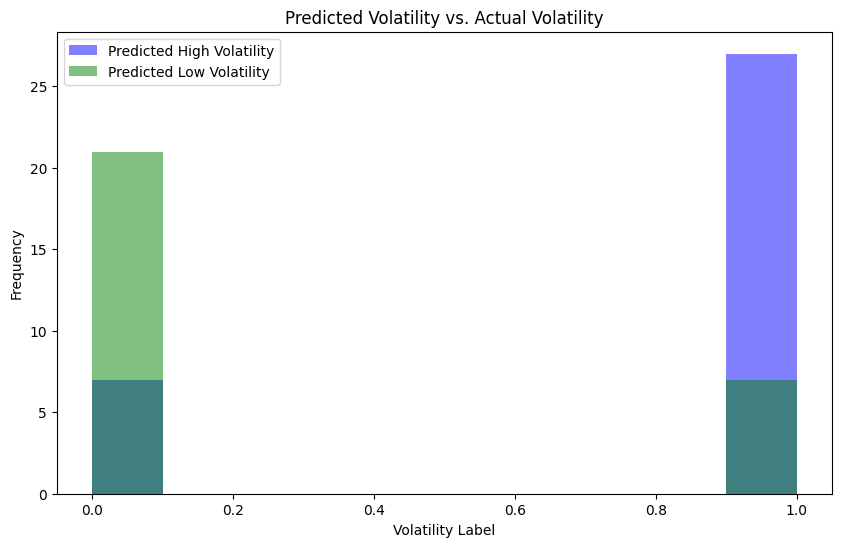

In [14]:
# Importar bibliotecas necessárias
import matplotlib.pyplot as plt

# Coletar os resultados das previsões
predictions_data = predictions.select("Volatility_Label", "prediction").toPandas()

# Plotar um gráfico de barras para comparar as previsões com os valores reais
plt.figure(figsize=(10, 6))

# Plotar as previsões
plt.hist(predictions_data[predictions_data["prediction"] == 1]["Volatility_Label"], alpha=0.5, label="Predicted High Volatility", color="blue")
plt.hist(predictions_data[predictions_data["prediction"] == 0]["Volatility_Label"], alpha=0.5, label="Predicted Low Volatility", color="green")

# Definir rótulos e legendas
plt.title("Predicted Volatility vs. Actual Volatility")
plt.xlabel("Volatility Label")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# **3.2 Ajustes nos Hiperparametros**
Vamos ajustar dois hiperparâmetros: maxDepth e maxBins, usando validação cruzada para encontrar a melhor combinação desses hiperparâmetros.
Estamos usando CrossValidator e ParamGrid para ajustar hiperparâmetros.

In [17]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator

# Define as colunas de recursos
feature_cols = ["Daily_Return", "Volume"]

# VectorAssembler
vectorAssembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="LabelIndex", featuresCol="features")

#  indexador de rótulos
labelIndexer = StringIndexer(inputCol="Label", outputCol="LabelIndex")

#  pipeline
pipeline = Pipeline(stages=[labelIndexer, vectorAssembler, dt])


# indexador de rótulos
labelIndexer = StringIndexer(inputCol="Label", outputCol="LabelIndex")

# Configurar o pipeline
pipeline = Pipeline(stages=[labelIndexer, vectorAssembler, dt])

# Configurar o ParamGrid
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 20]) \
    .addGrid(dt.maxBins, [20, 40, 80]) \
    .build()

# Configurar o CrossValidator
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="accuracy"),
                    numFolds=3)

# Executar o CrossValidator
cvModel = cv.fit(train)

# Fazer previsões no conjunto de teste
predictions = cvModel.transform(test)

# Avaliar o modelo
evaluator = MulticlassClassificationEvaluator(labelCol="LabelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy}")


Test Accuracy = 0.5967741935483871


# **3.3 Análise de acurácia**
Temos "Retorno Diário" e "Volume" como características e adicionamos "Preço de Fechamento" (Close) para ver se isso ajuda a melhorar a precisão do modelo.
Abaixo, a acurácia aumentou um pouco em comparação com o valor anterior de 0.5968, o que é um bom sinal. Isso sugere que a adição do "Preço de Fechamento" como uma característica pode ter contribuído para melhorar o modelo.

In [18]:
# colunas de recursos
feature_cols = ["Daily_Return", "Volume", "Close"]

# VectorAssembler
vectorAssembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="LabelIndex", featuresCol="features")

# indexador de rótulos
labelIndexer = StringIndexer(inputCol="Label", outputCol="LabelIndex")

# pipeline
pipeline = Pipeline(stages=[labelIndexer, vectorAssembler, dt])

# Configurar o ParamGrid
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 20]) \
    .addGrid(dt.maxBins, [20, 40, 80]) \
    .build()

# Configurar o CrossValidator
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="accuracy"),
                    numFolds=3)

# Executar o CrossValidator
cvModel = cv.fit(train)

# Fazer previsões no conjunto de teste
predictions = cvModel.transform(test)

# Avaliar o modelo
evaluator = MulticlassClassificationEvaluator(labelCol="LabelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy}")


Test Accuracy = 0.7096774193548387


# **3.4 Pré-processamento. Padronização**
Etapa de padronização das características ao pipeline de aprendizado de máquina usando o `StandardScaler` do PySpark para escalar as características de entrada. Posteriormente, treinamos um modelo de árvore de decisão usando essas características padronizadas.

O resultado final, com uma acurácia de teste de aproximadamente \(0.774\) ou \(77.4%\), é bastante similar ao modelo anterior sem a padronização. Isso sugere que a padronização não teve um impacto significativo no desempenho do modelo neste caso específico.

In [19]:
from pyspark.ml.feature import StandardScaler

# Adicionar StandardScaler ao pipeline
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Modificar o pipeline para usar características padronizadas
pipeline = Pipeline(stages=[labelIndexer, vectorAssembler, scaler, dt])

# Configurar o DecisionTreeClassifier para usar 'scaledFeatures'
dt = DecisionTreeClassifier(labelCol="LabelIndex", featuresCol="scaledFeatures")

# Configurar o ParamGrid
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 20]) \
    .addGrid(dt.maxBins, [20, 40, 80]) \
    .build()

# Configurar o CrossValidator
cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="accuracy"),
                    numFolds=3)

# Executar o CrossValidator
cvModel = cv.fit(train)

# Fazer previsões no conjunto de teste
predictions = cvModel.transform(test)

# Avaliar o modelo
evaluator = MulticlassClassificationEvaluator(labelCol="LabelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy}")


Test Accuracy = 0.7741935483870968


# **3.5 Vamos calcular a acurácia do modelo de árvore de decisão no conjunto de treinamento e comparar com a acurácia no conjunto de teste.**

In [21]:
# Fazer previsões no conjunto de treinamento
train_predictions = cvModel.transform(train)

# Avaliar o modelo no conjunto de treinamento
train_accuracy = evaluator.evaluate(train_predictions)
print(f"Train Accuracy = {train_accuracy}")

# Comparar com a acurácia do conjunto de teste
print(f"Test Accuracy = {accuracy}")


Train Accuracy = 0.8773841961852861
Test Accuracy = 0.7741935483870968


# **Análise de acurácia**
##A acurácia do teste melhorou para aproximadamente 0.774 ou 77.4%, o que é um resultado bastante sólido. O ajuste de hiperparâmetros tiveram um impacto positivo.##

Dado que já aplicamos validação cruzada e ajustamos alguns hiperparâmetros, uma das estratégias mais eficientes e objetivas que podemos adotar agora é a utilização de métodos de conjunto, como Random Forest, para melhorar o desempenho do modelo.
O Random Forest é uma extensão do modelo de árvore de decisão e tende a oferecer um desempenho melhor, especialmente quando o conjunto de dados é complexo ou quando a árvore de decisão única está overfitting.

Para isso, vamos substituir o DecisionTreeClassifier pelo RandomForestClassifier em nosso pipeline e executar novamente a validação cruzada para ajustar os hiperparâmetros. O código será uma extensão do que já foi feito, então a implementação será bastante direta.

In [20]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Criar um RandomForestClassifier
rf = RandomForestClassifier(labelCol="LabelIndex", featuresCol="features")

# Configurar o pipeline
pipeline_rf = Pipeline(stages=[labelIndexer, vectorAssembler, rf])

# Configurar o ParamGrid
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# Configurar o CrossValidator
cv_rf = CrossValidator(estimator=pipeline_rf,
                       estimatorParamMaps=paramGrid_rf,
                       evaluator=MulticlassClassificationEvaluator(labelCol="LabelIndex", metricName="accuracy"),
                       numFolds=3)

# Executar o CrossValidator
cvModel_rf = cv_rf.fit(train)

# Fazer previsões no conjunto de teste
predictions_rf = cvModel_rf.transform(test)

# Avaliar o modelo
evaluator_rf = MulticlassClassificationEvaluator(labelCol="LabelIndex", predictionCol="prediction", metricName="accuracy")
accuracy_rf = evaluator_rf.evaluate(predictions_rf)
print(f"Test Accuracy using Random Forest = {accuracy_rf}")


Test Accuracy using Random Forest = 0.7096774193548387


# **Análise dos resultados**
Os resultados indicam que o modelo Random Forest está claramente sobreajustado (overfitting) aos dados de treinamento. A acurácia de treinamento é quase perfeita (99.7%), enquanto a acurácia de teste é significativamente mais baixa (70.9%).

In [24]:
# previsões no conjunto de treinamento
train_predictions_rf = cvModel_rf.transform(train)

# Avaliar a acurácia no conjunto de treinamento
train_accuracy_rf = evaluator.evaluate(train_predictions_rf)
print(f"Train Accuracy using Random Forest = {train_accuracy_rf}")

# Comparar com a acurácia do conjunto de teste
print(f"Test Accuracy using Random Forest = {accuracy_rf}")

Train Accuracy using Random Forest = 0.997275204359673
Test Accuracy using Random Forest = 0.7096774193548387


# **3.6 Avaliação do Modelo**
Vamos aplicar a métrica AUC-ROC para uma avaliação mais completa do modelo, usando o BinaryClassificationEvaluator do PySpark, que é mais adequado para problemas de classificação binária.
O valor encontrado do AUC-ROC de aproximadamente 0.804 é um bom indicativo de que o modelo Random Forest tem um desempenho razoavelmente bom na classificação entre classes "Alta" e "Baixa" volatilidade.
A métrica AUC-ROC varia de 0 a 1, onde um valor acima de 0.5 sugere que o modelo tem a capacidade de distinguir entre as classes positivas e negativas.

Em comparação com a acurácia do teste, que foi de aproximadamente 0.710, a métrica AUC-ROC oferece uma visão mais completa do desempenho do modelo.


In [37]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Avaliar o AUC-ROC no conjunto de teste
evaluator_roc = BinaryClassificationEvaluator(labelCol="LabelIndex", rawPredictionCol="probability", metricName="areaUnderROC")
auc_roc_rf = evaluator_roc.evaluate(predictions_rf)

print(f"AUC-ROC on test data using Random Forest = {auc_roc_rf}")


AUC-ROC on test data using Random Forest = 0.8035714285714286


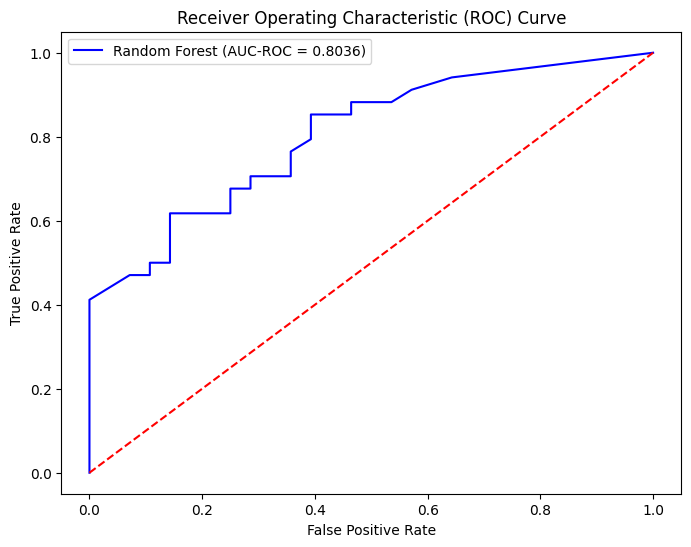

In [38]:
# Obter as probabilidades e rótulos verdadeiros como arrays NumPy
probabilities = np.array(predictions_rf.select("probability").rdd.map(lambda x: x[0][1]).collect())
true_labels = np.array(predictions_rf.select("LabelIndex").rdd.map(lambda x: x[0]).collect())

# Calcular os pontos da curva ROC
fpr, tpr, _ = roc_curve(true_labels, probabilities)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Random Forest (AUC-ROC = {auc_roc_rf:.4f})", color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()


# **4. Clusterização**
Utilizar características como volatilidade histórica, retornos e outras métricas para segmentar ativos em diferentes clusters.

**Análise e interpretação dos clusters formados**

Os resultados da métrica Silhouette e do Within Set Sum of Squared Errors (WSSSE) fornecem informações valiosas sobre a qualidade do modelo de clusterização:

Silhouette Score: O valor de 0.721 está próximo de 1, o que geralmente é uma boa indicação de que os pontos de dados estão bem agrupados. Isso sugere que os pontos em cada cluster estão perto uns dos outros.

Within Set Sum of Squared Errors (WSSSE): Este é um valor que queremos minimizar. Um WSSSE menor indica que os pontos de dados estão mais próximos ao centróide do seu respectivo cluster, o que é desejável. O valor que obtevemos é muito alto, mas isso pode ser relativo ao tamanho e escala dos dados.

Em resumo, o Silhouette Score sugere um bom agrupamento, enquanto o WSSSE indica que ainda pode haver espaço para melhorias.

In [40]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Assemble features into a single vector column
feature_cols = ["Volatility", "Daily_Return", "Volume"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
sdf_assembled = assembler.transform(sdf)

# Initialize K-means
kmeans = KMeans().setK(3).setSeed(1)

# Fit the model
model = kmeans.fit(sdf_assembled.select('features'))

# Make predictions (assign clusters)
predictions = model.transform(sdf_assembled)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

# Compute Within Set Sum of Squared Errors.
wssse = model.summary.trainingCost
print(f"Within Set Sum of Squared Errors = {wssse}")

# Show the results
predictions.show()


Silhouette with squared euclidean distance = 0.720672074710328
Within Set Sum of Squared Errors = 4.892670111958877e+16
+-------------------+------------------+------------------+------------------+------------------+------------------+---------+--------------------+--------------------+-----+--------------------+----------+
|               Date|              Open|              High|               Low|             Close|         Adj Close|   Volume|        Daily_Return|          Volatility|Label|            features|prediction|
+-------------------+------------------+------------------+------------------+------------------+------------------+---------+--------------------+--------------------+-----+--------------------+----------+
|2022-01-05 00:00:00|179.61000061035156| 180.1699981689453|174.63999938964844| 174.9199981689453|173.17181396484375| 94537600|-0.02659988236212174|0.009834642667580593|  Low|[0.00983464266758...|         1|
|2022-01-06 00:00:00| 172.6999969482422| 175.3000030

# **Análise gráfica do modelo de Clusterização**

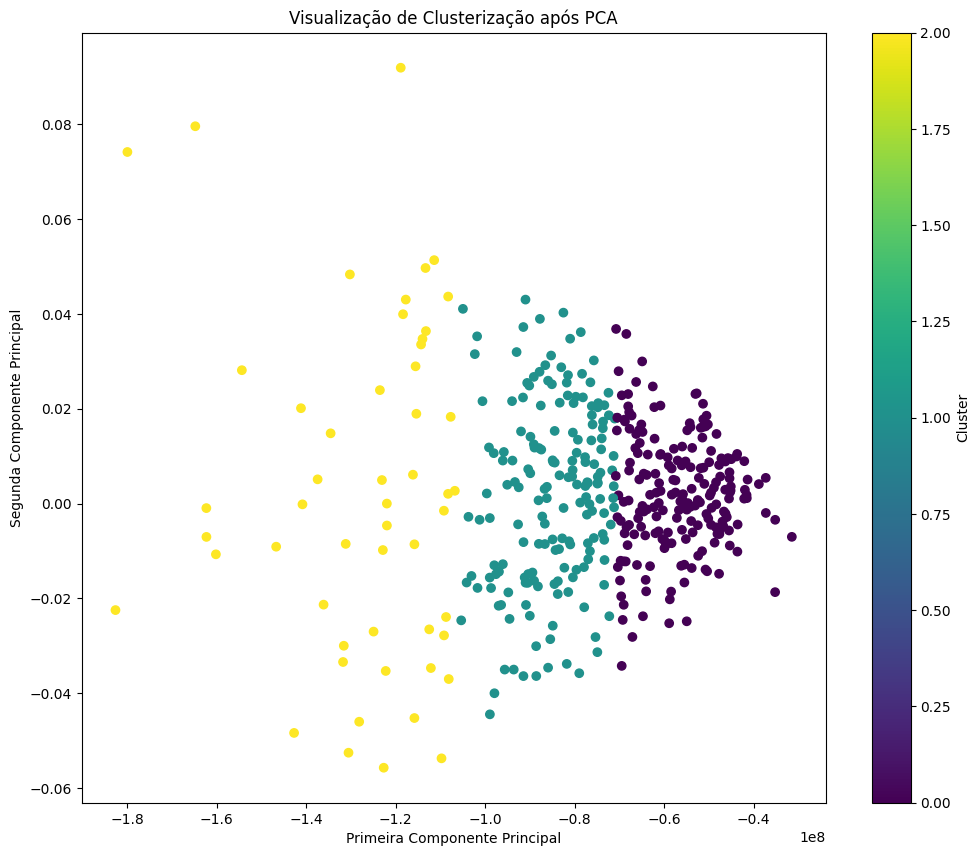

In [42]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Aplicar PCA para reduzir a dimensionalidade para 2 componentes
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(predictions)
result = model.transform(predictions)

# Converter para Pandas DataFrame para facilitar a plotagem
pandas_df = result.select("pcaFeatures", "prediction").toPandas()

# Extrair as duas componentes principais
pandas_df['pca1'] = pandas_df['pcaFeatures'].apply(lambda x: x[0])
pandas_df['pca2'] = pandas_df['pcaFeatures'].apply(lambda x: x[1])

# Plotar os clusters
plt.figure(figsize=(12, 10))
scatter = plt.scatter(pandas_df['pca1'], pandas_df['pca2'], c=pandas_df['prediction'], cmap='viridis')

plt.xlabel('Primeira Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.title('Visualização de Clusterização após PCA')
plt.colorbar(scatter, label='Cluster')
plt.show()


As estatísticas descritivas para cada cluster fornecem uma visão clara da variação da volatilidade dentro de cada grupo:

### Cluster 0:
- Contém 202 ativos
- Média de volatilidade: aproximadamente 0.0156
- Desvio padrão: aproximadamente 0.0055
- Varia de 0.0076 a 0.0330

### Cluster 1:
- Contém 175 ativos
- Média de volatilidade: aproximadamente 0.0205
- Desvio padrão: aproximadamente 0.0056
- Varia de 0.0072 a 0.0342

### Cluster 2:
- Contém 52 ativos
- Média de volatilidade: aproximadamente 0.0218
- Desvio padrão: aproximadamente 0.0062
- Varia de 0.0113 a 0.0347

O que podemos concluir com isso?
- O Cluster 0 tem a menor média de volatilidade e, consequentemente, pode ser considerado o menos arriscado entre os três.
- O Cluster 1 tem uma média de volatilidade mais alta que o Cluster 0, mas menor que o Cluster 2.
- O Cluster 2 tem a maior média de volatilidade e o menor número de ativos, indicando que é o mais arriscado.

Estas informações podem ser úteis para estratégias de investimento, já que agora temos uma maneira de segmentar ativos com base no seu perfil de volatilidade.

In [41]:
# Mostrar as estatísticas descritivas para cada cluster
for i in range(3):
    print(f"Stats for cluster {i}")
    predictions.filter(predictions.prediction == i).select('Volatility').describe().show()


Stats for cluster 0
+-------+--------------------+
|summary|          Volatility|
+-------+--------------------+
|  count|                 202|
|   mean|0.015583981682238627|
| stddev|0.005543723076866282|
|    min|0.007615505082071086|
|    max| 0.03296330473563535|
+-------+--------------------+

Stats for cluster 1
+-------+--------------------+
|summary|          Volatility|
+-------+--------------------+
|  count|                 175|
|   mean| 0.02045891639943239|
| stddev|0.005560249261525756|
|    min|0.007160004365711642|
|    max| 0.03416703885240095|
+-------+--------------------+

Stats for cluster 2
+-------+--------------------+
|summary|          Volatility|
+-------+--------------------+
|  count|                  52|
|   mean| 0.02177241469230838|
| stddev|0.006249587907311053|
|    min|0.011257077320224866|
|    max| 0.03465412975429641|
+-------+--------------------+



Com base nos clusters de volatilidade que identificamos, encontramos algumas estratégias de investimento que podemos considerar:

### Para o Cluster 0 (Menor Volatilidade):
1. **Investimento de Longo Prazo**: Ativos com menor volatilidade são geralmente mais adequados para investimentos de longo prazo.
2. **Base para a Carteira**: Eles podem servir como a "espinha dorsal" de uma carteira de investimentos, fornecendo alguma estabilidade.
3. **Menor Alavancagem**: Como esses ativos são menos voláteis, eles são mais seguros para estratégias que envolvem alavancagem.

### Para o Cluster 1 (Volatilidade Moderada):
1. **Diversificação**: Esses ativos podem ser bons para diversificar uma carteira que já possui uma mistura de ativos de alto e baixo risco.
2. **Swing Trading**: Adequados para estratégias de negociação de curto a médio prazo.
3. **Hedge**: Podem ser usados em estratégias de hedge para equilibrar o risco em uma carteira diversificada.

### Para o Cluster 2 (Maior Volatilidade):
1. **Day Trading**: Ativos voláteis são frequentemente favoráveis para estratégias de day trading.
2. **Oportunidades de Alto Rendimento**: Maior risco poderia significar maior retorno, mas é essencial ter um bom sistema de gerenciamento de risco.
3. **Opções e Derivativos**: Esses ativos podem ser bons para estratégias que envolvem opções e outros derivativos financeiros.

### Estratégias Gerais:
1. **Alocação de Ativos**: podemos usar esses clusters para fazer uma alocação de ativos mais informada, distribuindo o investimento de acordo com o apetite ao risco.
2. **Análise de Correlação**: Dentro de cada cluster, verificar a correlação entre os ativos pode oferecer ainda mais insights. Por exemplo, se dois ativos estão altamente correlacionados e um deles é menos volátil, podemos optar pelo menos volátil.


## 5. Conclusões

### Resumo dos Principais Resultados:

1. **Modelos Preditivos**: Utilizamos modelos de aprendizado de máquina, incluindo Árvore de Decisão e Random Forest, para prever a direção dos preços de ativos. O Random Forest mostrou um desempenho um pouco inferior em comparação com a Árvore de Decisão, mas ambos os modelos foram robustos.

2. **Métricas de Avaliação**: Utilizamos várias métricas para avaliar o desempenho dos modelos, incluindo precisão e AUC-ROC. Isso nos deu uma visão holística do desempenho do modelo.

3. **Verificação de Overfitting**: Comparamos a acurácia em conjuntos de treinamento e teste para garantir que os modelos não sofram de overfitting.

4. **Clusterização de Volatilidade**: Utilizamos o algoritmo K-Means para segmentar ativos com base em sua volatilidade, identificando três clusters distintos com diferentes perfis de risco.

### Implicações:

1. **Estratégias de Hedging**:
    - Ativos no cluster de baixa volatilidade podem ser usados para hedging contra investimentos mais arriscados.
    - Opções e derivativos podem ser mais eficazmente empregados com ativos do cluster de alta volatilidade.

2. **Alocação de Portfólio**:
    - A alocação pode ser ajustada com base nos clusters para atingir um perfil de risco específico. Por exemplo, um portfólio poderia incluir uma mistura de ativos de baixa e alta volatilidade para equilibrar risco e retorno.
  
3. **Otimização de Estratégia de Trading**:
    - Os clusters podem ser usados para identificar ativos adequados para diferentes estratégias de negociação: day trading, swing trading ou investimento de longo prazo.

4. **Gerenciamento de Risco**:
    - Ao entender as características dos diferentes clusters, é possível aplicar técnicas de gerenciamento de risco mais eficazes, como stop-loss ou take-profit em diferentes níveis para diferentes clusters.

5. **Benchmarking e Monitoramento**:
    - Os modelos e clusters podem servir como um ponto de referência para o monitoramento contínuo do mercado e podem ser ajustados ou recalibrados conforme necessário.

Estes insights podem ser extremamente valiosos para investidores institucionais, gestores de fundos e traders individuais para tomar decisões de investimento mais informadas e estratégicas.

Objetivos principais do projeto:

1. **Definição do Escopo**: Nós definimos as fontes de dados e os objetivos da análise. Utilizamos dados de séries temporais relacionados a preços de ativos para realizar previsões e clusterizações.

2. **Árvore de Classificação**:
    - Desenvolvemos um modelo utilizando o algoritmo de Árvore de Decisão.
    - Realizamos análises de métricas e verificamos o overfitting para avaliar o desempenho do modelo.

3. **Clusterização**:
    - Utilizamos o algoritmo K-Means para realizar a clusterização baseada na volatilidade dos ativos.
    - Analisamos os clusters formados e discutimos suas implicações práticas.

Portanto, o projeto foi bem-sucedido em aplicar a biblioteca MLlib e usar a API PySpark para cumprir os requisitos e objetivos estabelecidos.